In [190]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
font = {
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

# Inhibitory-Stabilised Network
Some initial conditions:

β = 1, 
τE = 20 ms, 
τI = 10 ms, 
V0 = −55 mV, 
Vrest = −70 mV, 
WEI = 0.65, 
WIE = 1.2,
WII = 0.5

## Network simulation

In [191]:
class EI_Network:
    def __init__(self):
        self.selected_network = 0
        self.V_I_clamp = False
        # neuron params
        self.beta = 1
        self.tau_E = 20
        self.tau_I = 10
        self.V_init = -55
        self.V_rest = -70
        # connection weights
        self.W_EI = 0.65
        self.W_IE = 1.2
        self.W_II = 0.5
        self.W_EE = 0
        # results
        self.VI = np.array([])
        self.VE = np.array([])
        
    def phi(self, V):
        # relu activation function
        v = self.beta * (V - self.V_init)
        return v * (v > 0)
    
    def select_network(self, network_number):
        self.selected_network = network_number
        if network_number == 1:
            self.W_EE = 0.5
        elif network_number == 2:
            # self.W_EE = 1.25
            self.W_EE = 1.25
        elif network_number == 3:
            # isolated excitatory network
            self.W_EE = 1
            self.W_EI = 0.0
            self.W_IE = 0.0
            self.W_II = 1
    
    def set_V_I_clamp(self, V_I_clamp):
        self.V_I_clamp = V_I_clamp

    def euler_simulate(self, N_t, dt, u_e, u_i):
        #
        u_e_size = len(u_e) if isinstance(u_e, list) else 1
        u_i_size = len(u_i) if isinstance(u_i, list) else 1
        n_neurons = max(u_e_size, u_i_size)
        
        # N_t+1 rows (N_t+init), n_neurons columns
        # Column is V of a SPECIFIC neuron OVER time
        # Row is V for ALL neurons AT a particular time
        VI = np.zeros([N_t+1, n_neurons]) + self.V_rest
        VE = np.zeros([N_t+1, n_neurons]) + self.V_rest
        print(f"Simulating with V_I clamp: {self.V_I_clamp}")
        for t in range(1, N_t+1):
            ve = VE[t-1]
            vi = VI[t-1]
            # excitatory
            # dVE = -(ve - self.V_rest) + u_e[t]
            dVE = -(ve - self.V_rest)  + self.W_EE * self.phi(ve) - self.W_EI * self.phi(vi) + u_e[t]
            VE[t] = ve + dt * dVE / self.tau_E
            # inhibitory
            # dVI = -(vi - self.V_rest) + u_i[t]
            dVI = -(vi - self.V_rest) + self.W_IE * self.phi(ve) - self.W_II * self.phi(vi) + u_i[t]
            VI[t] = VI[t-1] if self.V_I_clamp else (vi + dt * dVI / self.tau_I) 

        self.VI = VI
        self.VE = VE
    
    def plot_V_and_Phi(self, title):
        # plot Vs and Phi(Vs)
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        title = title if title else f'EI Network {self.selected_network}'
        fig.suptitle(title, fontsize=16)
        colors = ['green', 'red', 'blue', 'brown'] if self.selected_network == 2 else ['blue', 'orange', 'green', 'red']
        colors = ['blue', 'red', 'blue', 'red'][::-1]
        linestype = "--" if self.selected_network == 2 else "-"
        # V's
        axs[0].plot(self.VE, label='$V_E$', color=colors[0], linestyle=linestype)
        axs[0].plot(self.VI, label='$V_I$', color=colors[1], linestyle=linestype)
        axs[0].set_xlabel('Time (ms)')
        axs[0].set_ylabel('Voltage (mV)')
        axs[0].legend()
        axs[0].grid()
        axs[0].set_title('V vs Time')
        # Phi's
        axs[1].plot(self.phi(self.VE), label='$\phi(V_E)$', color=colors[0], linestyle=linestype)
        axs[1].plot(self.phi(self.VI), label='$\phi(V_I)$', color=colors[1], linestyle=linestype)
        axs[1].set_xlabel('Time (ms)')
        axs[1].set_ylabel('$\phi(V)$ $\delta$(mV)')
        axs[1].legend()
        axs[1].grid()
        axs[1].set_title('$\phi(V)$ vs Time')
        # 
        fig.tight_layout(pad=1.0)
        plt.show()

In [192]:
def plot_2_networks(u_e, u_i, title='EI Network 1 vs 2', V_I_clamp=False):
    colors = ['blue', 'orange', 'green', 'red']
    colors = ['blue', 'red', 'blue', 'red'][::-1]
    # network 1
    network = EI_Network()
    network.set_V_I_clamp(V_I_clamp)
    network.select_network(1)
    network.euler_simulate(len(u_e)-1, 1, u_e, u_i)
    VE1 = network.VE
    VI1 = network.VI
    # network 2
    network.select_network(2)
    network.euler_simulate(len(u_e)-1, 1, u_e, u_i)
    VE2 = network.VE
    VI2 = network.VI
    # plot
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    fig.suptitle(title, fontsize=16)
    # V's
    axs[0].plot(VE1, label='$V_E$ (1)', color=colors[0])
    axs[0].plot(VI1, label='$V_I$ (1)', color=colors[1])
    axs[0].plot(VE2, label='$V_E$ (2)', linestyle='--', color=colors[2])
    axs[0].plot(VI2, label='$V_I$ (2)', linestyle='--', color=colors[3])
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Voltage (mV)')
    axs[0].legend()
    axs[0].grid()
    axs[0].set_title('V vs Time')
    # Phi's
    axs[1].plot(network.phi(VE1), label='$\phi(V_E)$ (1)', color=colors[0])
    axs[1].plot(network.phi(VI1), label='$\phi(V_I)$ (1)', color=colors[1])
    axs[1].plot(network.phi(VE2), label='$\phi(V_E)$ (2)', linestyle='--', color=colors[2])
    axs[1].plot(network.phi(VI2), label='$\phi(V_I)$ (2)', linestyle='--', color=colors[3])
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('$\phi(V)$ $\delta$(mV)')
    axs[1].legend()
    axs[1].grid()
    axs[1].set_title('$\phi(V)$ vs Time')
    # 
    fig.tight_layout(pad=1.0)
    plt.show()

Simulating with V_I clamp: False
Simulating with V_I clamp: False


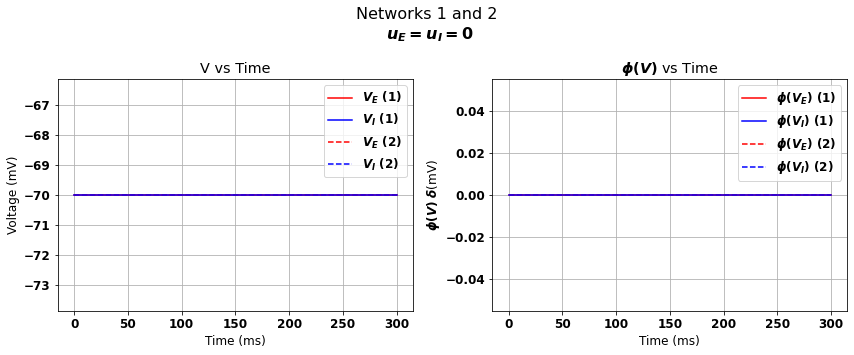

In [193]:
# instantiate the network
network = EI_Network()
# select network 1
network.select_network(1)
# simulate the network
N_t = 300
dt = 0.1
u_e = np.zeros(N_t+1)
u_i = np.zeros(N_t+1)

plot_2_networks(u_e, u_i, "Networks 1 and 2\n $u_E = u_I = 0$")

## 2. Network 1, stable equal input
Consider Network 1 and set $u_E = 20, u_I = 20$. Simulate equations (1-3) for Nt = 500
time steps (i.e., 500 ms real time). Plot VE and VI and ϕ(VE ), ϕ(VI ) as a function of time.
Comment on what you observe - how do the V terms differ from their ϕ(V ) counterparts and
how does this relate to their biological interpretation

Simulating with V_I clamp: False


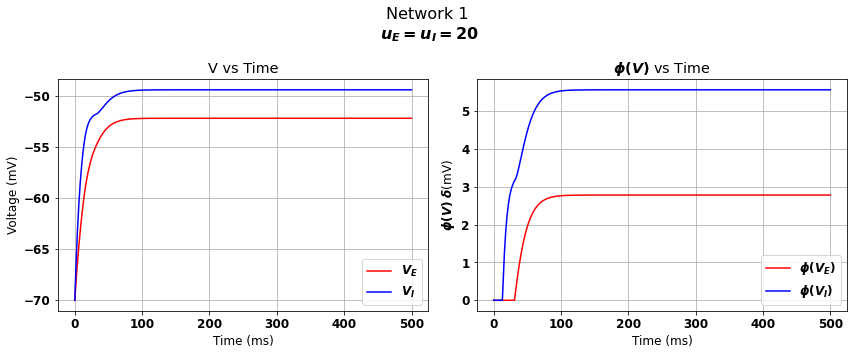

In [194]:

# setup
network.select_network(1)
Nt = 500
dt = 1
u_E = np.zeros([Nt+1]) + 20
u_I = np.zeros([Nt+1]) + 20
# simulate
# plot_2_networks(u_E, u_I, "Networks 1 and 2 with $u_E = u_I = 20$")
network.euler_simulate(Nt, dt, u_E, u_I)
network.plot_V_and_Phi("Network 1\n $u_E = u_I = 20$")



Simulating with V_I clamp: False


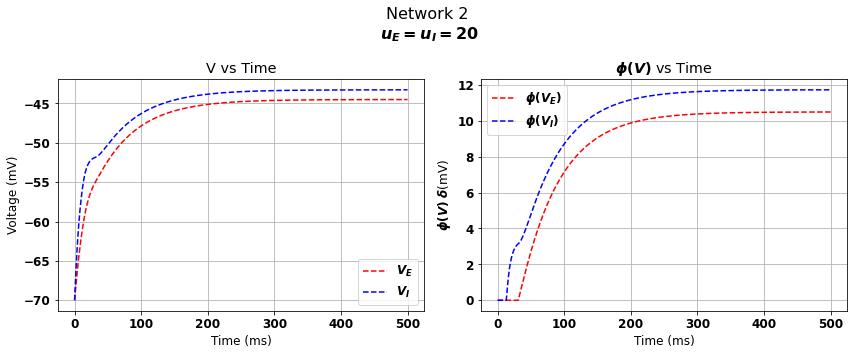

In [195]:
network.select_network(2)
Nt = 500
dt = 1
u_E = np.zeros([Nt+1]) + 20
u_I = np.zeros([Nt+1]) + 20
# simulate
network.euler_simulate(Nt, dt, u_E, u_I)
network.plot_V_and_Phi("Network 2\n $u_E = u_I = 20$")


Simulating with V_I clamp: False
Simulating with V_I clamp: False


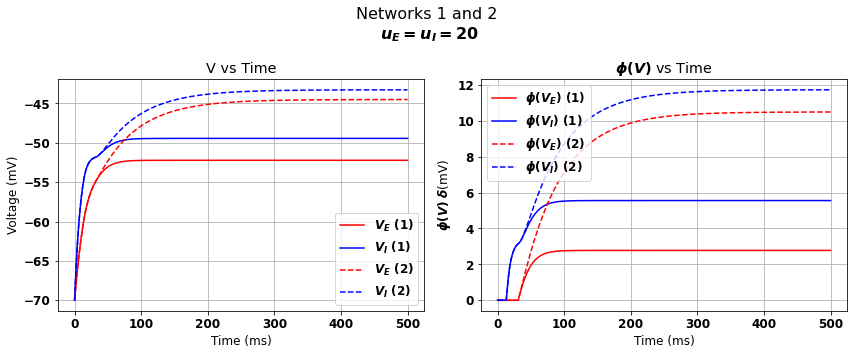

In [196]:
# for contrast 
u_E = np.zeros([Nt+1]) + 20
u_I = np.zeros([Nt+1]) + 20
plot_2_networks(u_E, u_I, "Networks 1 and 2\n $u_E = u_I = 20$")

### Comment:
The behaviour is similar, both neurons steadily increase their activity until they reach a stable state, where they plateau without further external input

V_I settles at a higher value as W_IE > W_EI, therefore increase in V_E excites V_I more than change in V_I does V_E, therefore when they reach a stable state, V_I is higher


## 3. Network 1, increased $u_I$ input
Repeat this simulation, this time:
- increasing uI after 500 time steps; and 
- simulating for a further 500 time steps at the new value 
- (Nt = 1000 in total, with 
- $u_I$ = 20 for the first 500 steps and $u_I$ = 26 for the second 500 steps). 

Plot VE , VI and ϕ(VE ), ϕ(VI ) as a function of
time. 

How do the E and I populations respond to the increase in $u_I$ - are these results in line
with intuition (justify your answer)?
 

Simulating with V_I clamp: False


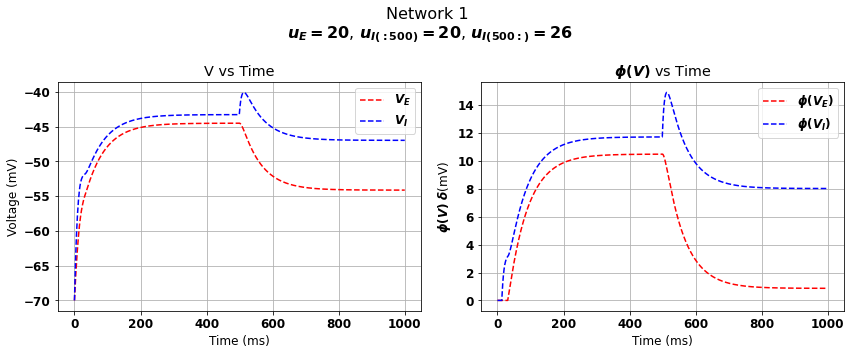

In [197]:
# setup
Nt = 1000
dt = 1
u_E = np.zeros([Nt+1]) + 20
u_I = np.zeros([Nt+1]) + 20
u_I[500:] = 26
# simulate
network.euler_simulate(Nt, dt, u_E, u_I)
# plot Vs and Phi(Vs)
network.plot_V_and_Phi("Network 1\n $u_E = 20$, $u_{I(:500)} = 20$, $u_{I (500:)} = 26$")
# plot_2_networks(u_E, u_I, "Networks 1 and 2 with $u_E = 20$mV, $u_{I_{:500}} = 20$mV, $u_{I_{500:}} = 26$mV")

### Comment:
With further increase in external current to I, V_I goes up inhibiting E and decreasing its activity from the previously stable state, however 30ms after the external input is increased, I suddenly inhibits itself and stabilises, while E continues to decrease

1-$\beta W_{EE}$


## 4. Network 2, increased $u_I$
Now perform the simulation of question 3 for Network 2. Plot the results as before. 

How do the results differ from Network 1? Why is the change in VI and ϕ(VI ) following increased
uI in Network 2 considered “paradoxical”

Simulating with V_I clamp: False


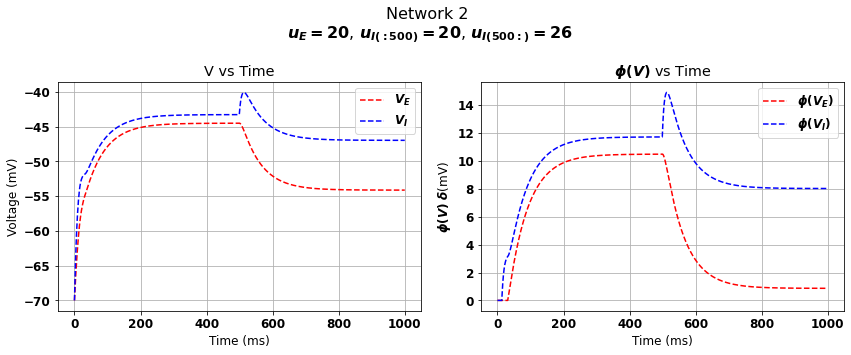

In [198]:
network.select_network(2)
# setup
Nt = 1000
dt = 1
u_E = np.zeros([Nt+1]) + 20
u_I = np.zeros([Nt+1]) + 20
u_I[500:] = 26
# simulate
network.euler_simulate(Nt, dt, u_E, u_I)
# plot Vs and Phi(Vs)
network.plot_V_and_Phi("Network 2\n $u_E = 20$, $u_{I(:500)} = 20$, $u_{I(500:)} = 26$")
# plot_2_networks(u_E, u_I, "Networks 1 and 2 with $u_E = 20$mV, $u_{I_{:500}} = 20$mV, $u_{I_{500:}} = 26$mV")

### Comment:
Higher W_EE makes the system takes longer to reach the stable state, while also increasing the level of stable membrane potential

The gap between the potentials has also shrunk as the W_IE superiority is balanced by much stronger E's W_EE self-feedback, making the 2 comoponents stronger coupled.

The behaviour after inhibitory input increase follows as before - gradual long decrease in V_E and sudden quick spike of V_I followed by a decrease to a substable level, where both plateau once again

Overall, the time scale of reaction increases - longer smoother curves. The V_I spike, however, seems to remain the same - 3.5mV change

The paradox here is that despite external current input to I increasing, the activity of the cell goes down, which is counterintuitive at first glance

Simulating with V_I clamp: False
Simulating with V_I clamp: False


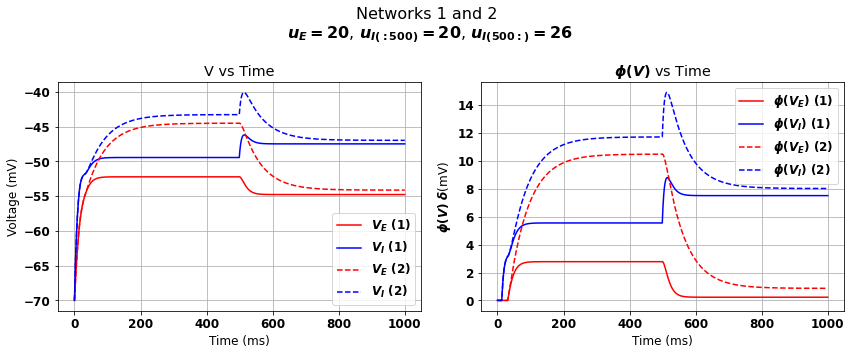

In [238]:
# now for contrast, plot both networks together
u_E = np.zeros([Nt+1]) + 20
u_I = np.zeros([Nt+1]) + 20
u_I[500:] = 26
plot_2_networks(u_E, u_I, "Networks 1 and 2\n $u_E = 20$, $u_{I(:500)} = 20$, $u_{I(500:)} = 26$")

## 5. Network 1 + 2, increased $u_E$.

Repeat the simulation of questions 3 and 4, but this time increase uE rather than uI . Plot
VE and VI and ϕ(VE ), ϕ(VI ) as a function of time for Networks 1 and 2. What happens if
you clamp VI to remain constant when you increase uE . How the two networks differ? How
do you interpret these results?

Simulating with V_I clamp: False
Simulating with V_I clamp: False


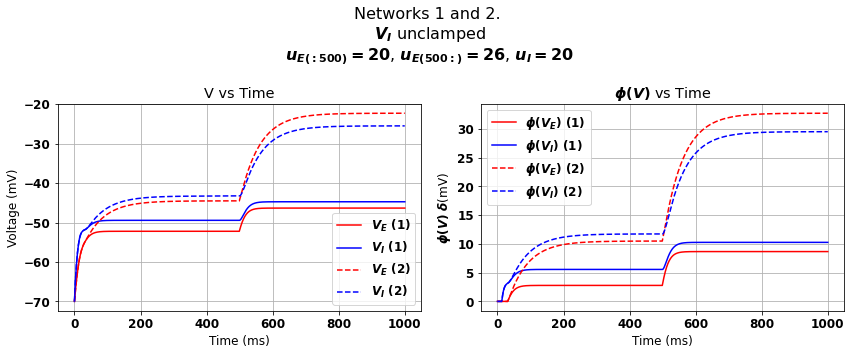

In [200]:
network.select_network(1)
# setup
Nt = 1000
dt = 1
u_E = np.zeros([Nt+1]) + 20
u_E[500:] = 26
u_I = np.zeros([Nt+1]) + 20
# simulate unclamped
network.V_I_clamp = False
plot_2_networks(u_E, u_I, "Networks 1 and 2.\n $V_I$ unclamped\n $u_{E(:500)} = 20$, $u_{E(500:)} = 26$, $u_I = 20$")
# network.euler_simulate(Nt, dt, u_E, u_I)
# # plot Vs and Phi(Vs)
# network.plot_V_and_Phi("Network 1\n $u_{E(:500)} = 20$, $u_{E(500:)} = 26$, $u_I = 20$")


Simulating with V_I clamp: True
Simulating with V_I clamp: True


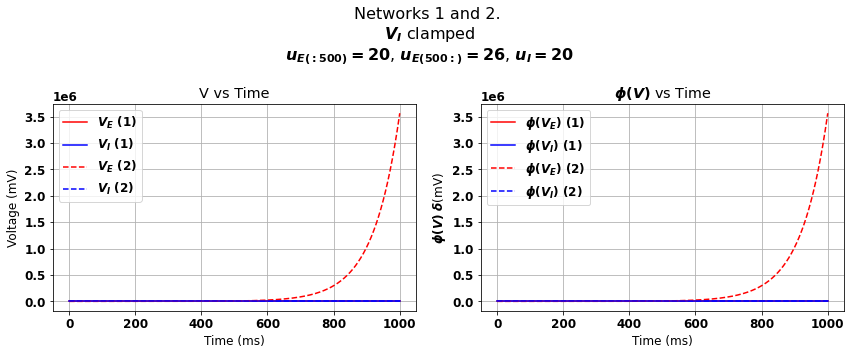

In [201]:
# setup
Nt = 1000
dt = 1
u_E = np.zeros([Nt+1]) + 20
u_E[500:] = 26
u_I = np.zeros([Nt+1]) + 20
# simulate clamped
plot_2_networks(u_E, u_I, "Networks 1 and 2.\n $V_I$ clamped\n $u_{E(:500)} = 20$, $u_{E(500:)} = 26$, $u_I = 20$", V_I_clamp=True)

### Comment

### Explore isolated excitatory component:

## 6.
A network is called “inhibitory-stabilised” if the excitatory subnetwork is unstable in isolation,
but the full excitatory-inhibitory network is stable. Based on the above simulations, can
you speculate on a relationship between inhibitory-stabilisation and paradoxical inhibition?
Explain your reasoning

### Comment:


## 7. 
Why are the above simulations not sufficient to demonstrate a general relationship between
paradoxical inhibition and inhibitory-stabilisation? How would you go about trying to find
out if this relationship holds more generally

### Comment

## 8. 
Assuming that this general relationship does hold within the model defined by equations
(1)-(3), suggest an experiment to test whether networks in the brain are in the inhibitory-
stabilised regime. Are there any caveats in this modelling approach that might limit your
confidence in making experimental predictions in this way?

### Comment